In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline, T5Tokenizer, T5EncoderModel
import torch
import re
import json
import numpy as np
import sys

## Negative Samples Creation w/ Embeddings and Coisne Similarity

Here we chose the approach to create embeddings from the prot_t5_xl model and then check if the embedding is in a certain "un-similarity range" which is a self-defined threshold. This becuase evaluations showed that this is (at least as far as we consider) the "best" approach.

In [2]:
read_path_beta = "../data/customDatasets/Stitchr_beta_concatenated.tsv"
stitchr_beta_df = pd.read_csv(read_path_beta, sep="\t")

/tmp/ipykernel_40529/1392729598.py:2: DtypeWarning: Columns (0,1,3,5,6,7,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  stitchr_beta_df = pd.read_csv(read_path_beta, sep="\t")


In [3]:
stitchr_beta_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
1,2,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
2,3,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
3,4,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
4,5,NaN,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,NaN,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,NaN,NaN,NaN,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51168,52874,NaN,ATGAGCATCAGCCTCCTGTGCTGTGCAGCCTTTCCTCTCCTGTGGG...,NaN,MSISLLCCAAFPLLWAGPVNAGVTQTPKFRILKIGQSMTLQCTQDM...,NaN,NaN,NaN,TRBV6-6*01,TRBJ1-6*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,CRVLCCYVL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,1.0
51169,52875,NaN,ATGCTGCTGCTTCTGCTGCTTCTGGGGCCAGGTATAAGCCTCCTTC...,NaN,MLLLLLLLGPGISLLLPGSLAGSGLGAVVSQHPSWVICKSGTSVKI...,NaN,NaN,NaN,TRBV20-1*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,CRVLCCYVL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,1.0
51170,52876,NaN,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,NaN,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,NaN,NaN,NaN,TRBV19*01,TRBJ2-5*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,CRVLCCYVL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,1.0
51171,52877,NaN,ATGGGCACAAGGTTGTTCTTCTATGTGGCCCTTTGTCTCCTGTGGA...,NaN,MGTRLFFYVALCLLWTGHMDAGITQSPRHKVTETGTPVTLRCHQTE...,NaN,NaN,NaN,TRBV10-3*01,TRBJ1-2*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,CRVLCCYVL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,1.0


In [4]:
len(set(stitchr_beta_df["Epitope"]))

1112

            Epitope  count
0         KLGGALQAK  12693
1         NLVPMVATV   5184
2         GILGFVFTL   4884
3        LPRRSGAAGA   2301
4         GLCTLVAML   2002
...             ...    ...
1107      LSDRVVFVL      1
1108      YTDINGNLH      1
1109      VIYMGTLSY      1
1110      SSGDATTAY      1
1111  AVVQSELPYPEGS      1

[1112 rows x 2 columns]


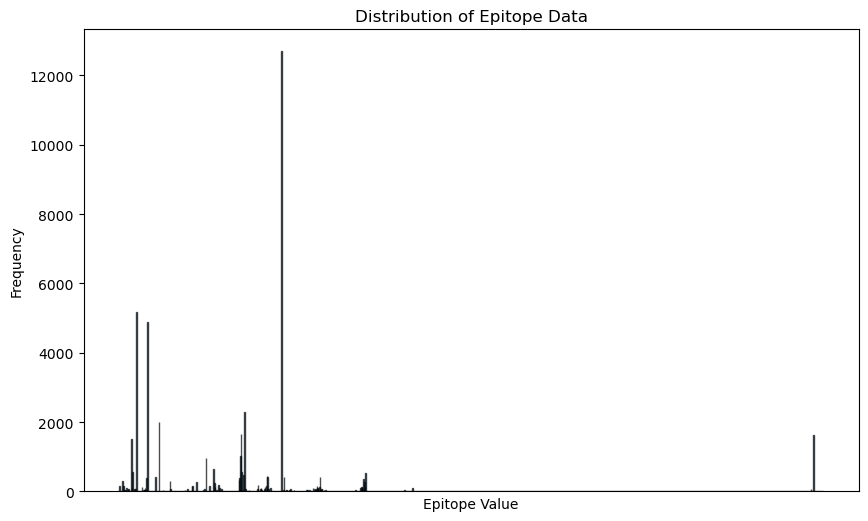

In [5]:
stitchr_beta_df['Epitope'] = stitchr_beta_df['Epitope'].astype(str)
epitope_counts = stitchr_beta_df['Epitope'].value_counts().reset_index()
print(epitope_counts)
epitope_counts.columns = ['Epitope Name', 'Count'] 

plt.figure(figsize=(10, 6))
plt.hist(stitchr_beta_df['Epitope'], bins=len(epitope_counts), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [6]:
# print(epitope_counts.to_string())

In [7]:
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))
'''

'\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available() else \'cpu\')\nprint("Using device: {}".format(device))\n'

In [8]:
'''
#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
if device==torch.device("cpu"):
  print("Casting model to full precision for running on CPU ...")
  model.to(torch.float32) # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True)
'''

'\n#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }\n# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision)\ntransformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"\nprint("Loading: {}".format(transformer_link))\nmodel = T5EncoderModel.from_pretrained(transformer_link)\nif device==torch.device("cpu"):\n  print("Casting model to full precision for running on CPU ...")\n  model.to(torch.float32) # only cast to full-precision if no GPU is available\nmodel = model.to(device)\nmodel = model.eval()\ntokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False, legacy=True)\n'

In [9]:
epitopes = set(stitchr_beta_df["Epitope"].to_list())

In [10]:
# this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
processed_epitopes = [(sequence, " ".join(list(re.sub(r"[UZOB]", "X", sequence)))) for sequence in epitopes]
# processed_epitopes

In [11]:
def process_batch(processed_seqs):
    # Extract just the processed sequences for tokenization
    sequences = [seq[1] for seq in processed_seqs]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest", return_tensors="pt")
    input_ids = ids['input_ids'].to(device)
    attention_mask = ids['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    last_hidden_states = outputs.last_hidden_state
    
    # Now, return embeddings mapped to the original sequence
    embeddings = {}
    for i, (original_seq, _) in enumerate(processed_seqs):
        seq_len = attention_mask[i].sum().item() - 2  # Subtract [CLS] and [SEP]
        valid_embeddings = last_hidden_states[i, 1:seq_len+1]
        mean_embedding = valid_embeddings.mean(dim=0)
        embeddings[original_seq] = mean_embedding.cpu().numpy()  # Use original sequence as key
    
    return embeddings

In [12]:
to_path = "../data/customDatasets/negative_samples/temp"
file_name = "Stitchr_beta_concatenated_with_epitope_embedding.tsv"

In [13]:
'''
batch_size = 128
sequence_to_embedding = {}

# Batch processing with a dictionary, using original sequences as keys
for i in range(0, len(processed_epitopes), batch_size):
    batch_sequences = processed_epitopes[i:i+batch_size]
    batch_embeddings = process_batch(batch_sequences)
    sequence_to_embedding.update(batch_embeddings)

    stitchr_beta_df["Epitope Embedding"] = stitchr_beta_df["Epitope"].map(sequence_to_embedding)

# This is needed becuase the embedding is huge and otherwise it would be stored with line breaks (\n) 
# This would make it difficult while reading the file
stitchr_beta_df['Epitope Embedding'] = stitchr_beta_df['Epitope Embedding'].apply(lambda x: json.dumps(x.tolist()))

stitchr_beta_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)
'''


'\nbatch_size = 128\nsequence_to_embedding = {}\n\n# Batch processing with a dictionary, using original sequences as keys\nfor i in range(0, len(processed_epitopes), batch_size):\n    batch_sequences = processed_epitopes[i:i+batch_size]\n    batch_embeddings = process_batch(batch_sequences)\n    sequence_to_embedding.update(batch_embeddings)\n\n    stitchr_beta_df["Epitope Embedding"] = stitchr_beta_df["Epitope"].map(sequence_to_embedding)\n\n# This is needed becuase the embedding is huge and otherwise it would be stored with line breaks (\n) \n# This would make it difficult while reading the file\nstitchr_beta_df[\'Epitope Embedding\'] = stitchr_beta_df[\'Epitope Embedding\'].apply(lambda x: json.dumps(x.tolist()))\n\nstitchr_beta_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)\n'

The cell above is commented out to safe time. After changing something in the underlaying dataset re-run this cell to create the up-to-date embeddings!

In [14]:

stitchr_beta_df = pd.read_csv(to_path+"/"+file_name, sep="\t")
stitchr_beta_df['Epitope Embedding'] = stitchr_beta_df['Epitope Embedding'].apply(lambda x: np.array(json.loads(x)))

/tmp/ipykernel_40529/3863822543.py:1: DtypeWarning: Columns (0,1,3,5,6,7,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  stitchr_beta_df = pd.read_csv(to_path+"/"+file_name, sep="\t")


In [15]:
max_index = len(stitchr_beta_df) - 1 
negative_epitopes_cosine = []

In [16]:
def cosine_similarity(embedding1, embedding2): 
    cosine = np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return cosine

In [17]:
def is_valid_negative(cosine_similarity, current_epitope, random_epitope): 
    is_valid = False
    cosine_min = -0.75
    cosine_max = 0.75

    if (cosine_similarity >= cosine_min \
        and cosine_similarity <= cosine_max) \
        and (current_epitope != random_epitope): 
        is_valid = True 

    return is_valid


In [18]:
sys_max_depth = sys.getrecursionlimit()
max_attempts_by_system = sys_max_depth - 1

In [20]:
len(stitchr_beta_df["Epitope"])

51173

In [21]:
def search_negative_epitope_embedding(df, index, current_epitope, max_attempts=max_attempts_by_system):
    current_embedding = df["Epitope Embedding"][index]
    attempt = 0
    
    while attempt < max_attempts:
        random_epitope_index = np.random.randint(0, len(df))
        random_epitope = df["Epitope"][random_epitope_index]
        
        if random_epitope_index == index:
            attempt += 1
            continue  # Skip the rest of the loop and try again
        
        random_epitope_embedding = df["Epitope Embedding"][random_epitope_index]
        cosine = cosine_similarity(current_embedding, random_epitope_embedding)
        
        if is_valid_negative(cosine, current_epitope, random_epitope) or attempt == max_attempts - 1:
            return random_epitope  # Return the found valid or last attempt epitope
        
        attempt += 1
    
    # This point should theoretically never be reached because of the check in the loop,
    # but it's a fallback to return a random different epitope if for some reason it does.
    while True:
        random_epitope_index = np.random.randint(0, len(df))
        if random_epitope_index != index:
            return df["Epitope"][random_epitope_index]

for i, epitope in enumerate(stitchr_beta_df["Epitope"]):
    negative_epitope = search_negative_epitope_embedding(stitchr_beta_df, i, epitope)
    negative_epitopes_cosine.append(negative_epitope)


In [22]:
len((negative_epitopes_cosine))

51173

In [23]:
negative_epitopes_cosine_dict = {"Negative Epitope": negative_epitopes_cosine}
negative_epitopes_cosine_df = pd.DataFrame(negative_epitopes_cosine_dict)
# print(negative_epitopes_cosine_df.to_string())
negative_epitopes_cosine_df

,Negative Epitope
0,GILGFVFTL
1,KRWIILGLNK
2,PKYVKQNTLKLAT
3,NLVPMVATV
4,GILGFVFTL
...,...
51168,KLGGALQAK
51169,GILGFVFTL
51170,KLGGALQAK
51171,RFYKTLRAEQASQ


    Epitope Name  Count
0      GILGFVFTL   8882
1      KLGGALQAK   5619
2      GLCTLVAML   3921
3      NLVPMVATV   3490
4     ELAGIGILTV   3286
..           ...    ...
894    CISSCNPNL      1
895    TGAIKLDDK      1
896    MFDAYVNTF      1
897    KMFDAYVNT      1
898    LYPEFIASI      1

[899 rows x 2 columns]


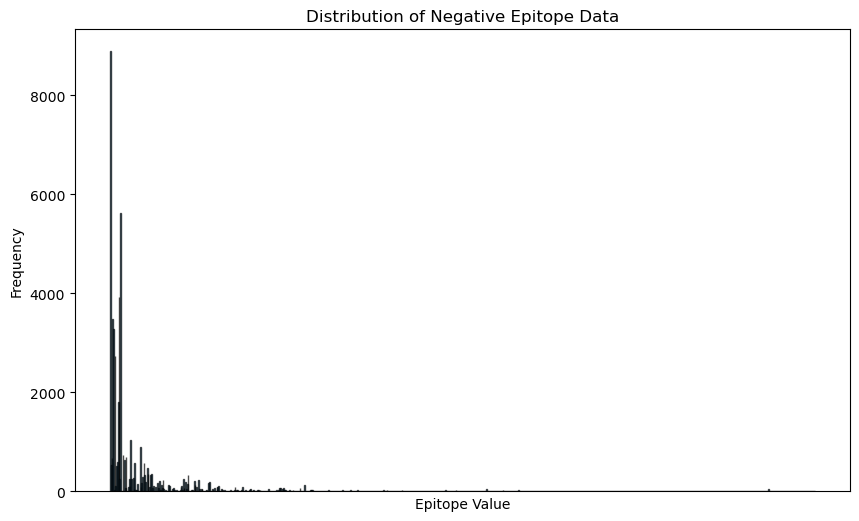

In [26]:
epitope_counts_negative = negative_epitopes_cosine_df['Negative Epitope'].value_counts().reset_index()
epitope_counts_negative.columns = ['Epitope Name', 'Count']
print(epitope_counts_negative) 

plt.figure(figsize=(10, 6))
plt.hist(negative_epitopes_cosine_df['Negative Epitope'].astype(str), bins=len(epitope_counts_negative), edgecolor='k', alpha=0.7)
plt.xlabel('Epitope Value')
plt.ylabel('Frequency')
plt.title('Distribution of Negative Epitope Data')
plt.xticks([])  # removes the x-axis labels
plt.show()

In [27]:
stitchr_beta_df.columns

Index(['TCR_name', 'TRA_nt', 'TRB_nt', 'TRA_aa', 'TRB_aa', 'TRAV', 'TRAJ',
       'TRA_CDR3', 'TRBV', 'TRBJ', 'TRB_CDR3', 'TRAC', 'TRBC', 'TRA_leader',
       'TRB_leader', 'Linker', 'Link_order', 'TRA_5_prime_seq',
       'TRA_3_prime_seq', 'TRB_5_prime_seq', 'TRB_3_prime_seq', 'Linked_nt',
       'Linked_aa', 'Warnings/Errors', 'Epitope', 'Score', 'MHC A', 'MHC B',
       'MHC class', 'Binding', 'Epitope Embedding'],
      dtype='object')

In [30]:
stitchr_beta_with_negative_df = stitchr_beta_df.drop(["Epitope Embedding"], axis=1).copy(deep=True)
stitchr_beta_with_negative_df["Binding"] = 0
stitchr_beta_with_negative_df["Epitope"] = negative_epitopes_cosine
stitchr_beta_with_negative_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],GILGFVFTL,2.0,HLA-B*08,B2M,MHCI,0
1,2,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],KRWIILGLNK,2.0,HLA-B*08,B2M,MHCI,0
2,3,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],PKYVKQNTLKLAT,2.0,HLA-B*08,B2M,MHCI,0
3,4,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],NLVPMVATV,2.0,HLA-B*08,B2M,MHCI,0
4,5,NaN,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,NaN,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,NaN,NaN,NaN,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],GILGFVFTL,2.0,HLA-B*08,B2M,MHCI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51168,52874,NaN,ATGAGCATCAGCCTCCTGTGCTGTGCAGCCTTTCCTCTCCTGTGGG...,NaN,MSISLLCCAAFPLLWAGPVNAGVTQTPKFRILKIGQSMTLQCTQDM...,NaN,NaN,NaN,TRBV6-6*01,TRBJ1-6*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,KLGGALQAK,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0
51169,52875,NaN,ATGCTGCTGCTTCTGCTGCTTCTGGGGCCAGGTATAAGCCTCCTTC...,NaN,MLLLLLLLGPGISLLLPGSLAGSGLGAVVSQHPSWVICKSGTSVKI...,NaN,NaN,NaN,TRBV20-1*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0
51170,52876,NaN,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,NaN,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,NaN,NaN,NaN,TRBV19*01,TRBJ2-5*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,KLGGALQAK,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0
51171,52877,NaN,ATGGGCACAAGGTTGTTCTTCTATGTGGCCCTTTGTCTCCTGTGGA...,NaN,MGTRLFFYVALCLLWTGHMDAGITQSPRHKVTETGTPVTLRCHQTE...,NaN,NaN,NaN,TRBV10-3*01,TRBJ1-2*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,RFYKTLRAEQASQ,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0


In [31]:
stitchr_beta_with_negative_df = pd.concat([stitchr_beta_df.drop(["Epitope Embedding"], axis=1).copy(deep=True), stitchr_beta_with_negative_df], axis=0)
stitchr_beta_with_negative_df["TCR_name"] = range(1, len(stitchr_beta_with_negative_df)+1)
stitchr_beta_with_negative_df

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors,Epitope,Score,MHC A,MHC B,MHC class,Binding
0,1,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
1,2,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
2,3,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
3,4,NaN,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,NaN,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,NaN,NaN,NaN,TRBV13*01,TRBJ1-5*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
4,5,NaN,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,NaN,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,NaN,NaN,NaN,TRBV14*01,TRBJ2-1*01,...,NaN,NaN,NaN,[None],FLKEKGGL,2.0,HLA-B*08,B2M,MHCI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51168,102342,NaN,ATGAGCATCAGCCTCCTGTGCTGTGCAGCCTTTCCTCTCCTGTGGG...,NaN,MSISLLCCAAFPLLWAGPVNAGVTQTPKFRILKIGQSMTLQCTQDM...,NaN,NaN,NaN,TRBV6-6*01,TRBJ1-6*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,KLGGALQAK,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0.0
51169,102343,NaN,ATGCTGCTGCTTCTGCTGCTTCTGGGGCCAGGTATAAGCCTCCTTC...,NaN,MLLLLLLLGPGISLLLPGSLAGSGLGAVVSQHPSWVICKSGTSVKI...,NaN,NaN,NaN,TRBV20-1*01,TRBJ2-7*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,GILGFVFTL,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0.0
51170,102344,NaN,ATGAGCAACCAGGTGCTCTGCTGTGTGGTCCTTTGTTTCCTGGGAG...,NaN,MSNQVLCCVVLCFLGANTVDGGITQSPKYLFRKEGQNVTLSCEQNL...,NaN,NaN,NaN,TRBV19*01,TRBJ2-5*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,KLGGALQAK,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0.0
51171,102345,NaN,ATGGGCACAAGGTTGTTCTTCTATGTGGCCCTTTGTCTCCTGTGGA...,NaN,MGTRLFFYVALCLLWTGHMDAGITQSPRHKVTETGTPVTLRCHQTE...,NaN,NaN,NaN,TRBV10-3*01,TRBJ1-2*01,...,NaN,NaN,NaN,(TRB) No valid leader region allele determined...,RFYKTLRAEQASQ,NaN,HLA-C*07:02,HLA-C*07:02,MHCI,0.0


In [32]:
to_path = "../data/customDatasets/negative_samples/"
file_name = "Stitchr_beta_concatenated_with_negative.tsv"

In [33]:
stitchr_beta_with_negative_df.to_csv(to_path+"/"+file_name, sep="\t", index=False)